### K近邻元素分类器伪代码
- 设置算法所需参数：K（最近邻元素个数）、和D（训练集）；
- for每个测试样例$z=(x^{\prime},y^{\prime})$, do

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### 1、创建简单数据集

In [13]:
def createDataSet():
    group = np.array([[1.0,1.1],[1.0,1.0],[0,0],[0,0.1]])
    labels = ['A','A','B','B']
    return group, labels

In [14]:
group,labels = createDataSet()
group, labels

(array([[1. , 1.1],
        [1. , 1. ],
        [0. , 0. ],
        [0. , 0.1]]), ['A', 'A', 'B', 'B'])

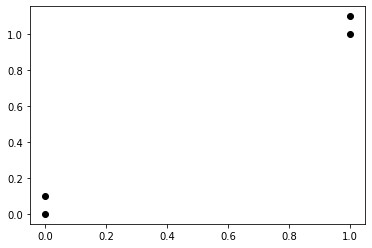

In [15]:
plt.plot(group[:,0],group[:,1],'o',color = 'black')

### 2、构造分类器

In [16]:
def classify0(inX,dataSet,labels,k):
    dataSetSize = dataSet.shape[0]
    diffMat = np.tile(inX,(dataSetSize,1)) - dataSet
    sqDiffMat = diffMat**2
    sqDistances = sqDiffMat.sum(axis=1)
    distances = sqDistances**0.5
    sortedDistIndicies = distances.argsort()
    classCount = {}
    for i in range(k):
        voteIlabel = labels[sortedDistIndicies[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
    sortedClassCount = sorted(classCount.items(),key = lambda x:x[1],reverse = True)
    return sortedClassCount[0][0]

In [17]:
classify0([0,1.2],group,labels,3)

'A'

### 总结
- 以原生Python对象为主；
- 以list为容器存放迭代对象；
- 用dict构造层级索引关系进行计数；
- 部分语句用到numpy中数组对象；

## 二、利用高级数据结构优化算法

In [39]:
def classify0_1(train,test,k):
    n = train.shape[1] - 1
    m = test.shape[0]
    result = [ ]
    for i in range(m):
        dist = list(((train.iloc[:,:n] - test.iloc[i,:n] )**2).sum(1))
        dist_1 = pd.DataFrame({'dist':dist,'labels':(train.iloc[:,n])})
        dr = dist_1.sort_values(by = 'dist')[:k]
        re = dr.loc[:,'labels'].value_counts()
        result.append(re.index[0])
    result = pd.Series(result)
    test['predict'] = result
    return test

In [19]:
group,labels = createDataSet()
train = np.vstack([group,[0,0]])
labels.append('B')

In [20]:
train = pd.DataFrame({'x1':train[:,0],'x2':train[:,1],'labels':labels})
train = train.reindex(['x1'] + ['x2'] + ['labels'],axis = 1)

In [21]:
p1 = [1,2]
p2 = [0,1]
test = pd.DataFrame({'x1':p1,'x2':p2})

In [22]:
result = classify0_1(train, test, 3)

In [23]:
result

,x1,x2,predict
0,1,0,B
1,2,1,A


In [24]:
result.columns = ['x1','x2','labels']
result

,x1,x2,labels
0,1,0,B
1,2,1,A


In [25]:
input = pd.concat([train,result],ignore_index = True)
input

,x1,x2,labels
0,1.0,1.1,A
1,1.0,1.0,A
2,0.0,0.0,B
3,0.0,0.1,B
4,0.0,0.0,B
5,1.0,0.0,B
6,2.0,1.0,A


In [26]:
input['Ind1'] = 1
for i in range(input.shape[0]):
    if(input.iloc[i,2] == 'B'):
        input.iloc[i,3] = 0
input['Ind2'] = [1,1,1,1,1,0.5,0.5]
input

,x1,x2,labels,Ind1,Ind2
0,1.0,1.1,A,1,1.0
1,1.0,1.0,A,1,1.0
2,0.0,0.0,B,0,1.0
3,0.0,0.1,B,0,1.0
4,0.0,0.0,B,0,1.0
5,1.0,0.0,B,0,0.5
6,2.0,1.0,A,1,0.5


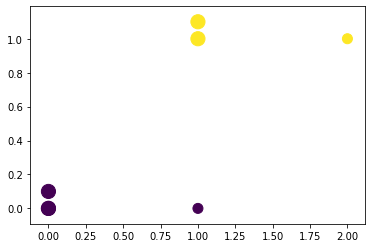

In [27]:
plt.scatter(input.iloc[:,0],input.iloc[:,1],s=200*input.iloc[:,4],c=input.iloc[:,3])

### 图形美化

In [38]:
def nearestPoint(train,result):
    m = train.shape[0]
    n = result.shape[0]
    uq = train.iloc[:,-1].unique()
    k = uq.shape[0]
    ind1 = pd.Series(index=range(m+n))
    ind2 = pd.Series(index=range(m+n))
    ind2[:m] = 1
    ind2[m:] =2
    if(train.shape[1] == result.shape[1]):
        result.columns = train.columns
        input = pd.concat([train,result],ignore_index=True)
        for i in range(k):
            ind1[input.loc[:,'labels']== uq[i]] = i + 1
        output = pd.concat([input,ind1,ind2],axis=1)
    plt.scatter(output.iloc[:,0],output.iloc[:,1],s=200*output.iloc[:,-1],c=output.iloc[:,-2])
    return output
        

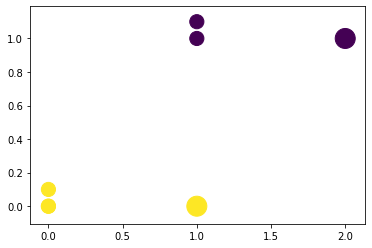

In [29]:
output = nearestPoint(train,result)

## 三、读取外部数据集执行算法

In [40]:
iris = pd.read_csv('E:\Ynu_courses\statlearn\data\iris.csv')
iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [41]:
import random
random.seed(2020)
def randSplit(dataSet, rate):
    li = list(dataSet.index)
    random.shuffle(li)
    dataSet.index = li
    n = dataSet.shape[0]
    m = int(n * rate)
    train = dataSet.loc[range(m),:]
    test = dataSet.loc[range(m,n),:]
    dataSet.index = range(dataSet.shape[0])
    test.index = range(test.shape[0])
    return train, test

In [42]:
train, test = randSplit(iris,0.8)

In [43]:
result = classify0_1(train,test,3)

In [44]:
train.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.7,1.5,0.4,setosa
1,5.1,3.8,1.9,0.4,setosa
2,4.8,3.4,1.6,0.2,setosa
3,7.2,3.6,6.1,2.5,virginica
4,5.5,4.2,1.4,0.2,setosa


In [45]:
result

,sepal_length,sepal_width,petal_length,petal_width,species,predict
0,6.1,2.6,5.6,1.4,virginica,virginica
1,6.3,2.5,5.0,1.9,virginica,virginica
2,6.3,2.5,4.9,1.5,versicolor,virginica
3,5.7,2.6,3.5,1.0,versicolor,versicolor
4,6.3,2.3,4.4,1.3,versicolor,versicolor
5,7.4,2.8,6.1,1.9,virginica,virginica
6,5.0,2.0,3.5,1.0,versicolor,versicolor
7,6.4,3.2,5.3,2.3,virginica,virginica
8,5.4,3.9,1.3,0.4,setosa,setosa
9,5.1,3.8,1.5,0.3,setosa,setosa


### 模型完善
- 归一化方法；
- 模型评估指标；

In [17]:
def MaxMinNormalization(dataSet):
    maxDf = dataSet.max()
    minDf = dataSet.min()
    normSet = (dataSet - minDf)/(maxDf - minDf)
    return normSet

In [20]:
iris_t = pd.concat([MaxMinNormalization(iris.iloc[:,:4]),iris.iloc[:,4]],axis=1 )

In [21]:
iris_t

,sepal_length,sepal_width,petal_length,petal_width,species
0,0.222222,0.625000,0.067797,0.041667,setosa
1,0.166667,0.416667,0.067797,0.041667,setosa
2,0.111111,0.500000,0.050847,0.041667,setosa
3,0.083333,0.458333,0.084746,0.041667,setosa
4,0.194444,0.666667,0.067797,0.041667,setosa
...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,virginica
146,0.555556,0.208333,0.677966,0.750000,virginica
147,0.611111,0.416667,0.711864,0.791667,virginica
148,0.527778,0.583333,0.745763,0.916667,virginica


In [24]:
def Z_ScoreNormalization(dataSet):
    stdDf = dataSet.std()
    meanDf = dataSet.mean()
    normSet = (dataSet - meanDf) / stdDf
    return normSet

In [25]:
iris_z = pd.concat([Z_ScoreNormalization(iris.iloc[:,:4]),iris.iloc[:,4]],axis = 1)
iris_z

,sepal_length,sepal_width,petal_length,petal_width,species
0,-0.897674,1.028611,-1.336794,-1.308593,setosa
1,-1.139200,-0.124540,-1.336794,-1.308593,setosa
2,-1.380727,0.336720,-1.393470,-1.308593,setosa
3,-1.501490,0.106090,-1.280118,-1.308593,setosa
4,-1.018437,1.259242,-1.336794,-1.308593,setosa
...,...,...,...,...,...
145,1.034539,-0.124540,0.816888,1.443121,virginica
146,0.551486,-1.277692,0.703536,0.918985,virginica
147,0.793012,-0.124540,0.816888,1.050019,virginica
148,0.430722,0.797981,0.930239,1.443121,virginica


In [35]:
def sigmoNormalization(dataSet):
    normSet = 1/(1+np.exp(-dataSet))
    return normSet

In [36]:
iris_s = pd.concat([sigmoNormalization(iris.iloc[:,:4]),iris.iloc[:,4]],axis=1)
iris_s

,sepal_length,sepal_width,petal_length,petal_width,species
0,0.993940,0.970688,0.802184,0.549834,setosa
1,0.992608,0.952574,0.802184,0.549834,setosa
2,0.990987,0.960834,0.785835,0.549834,setosa
3,0.990048,0.956893,0.817574,0.549834,setosa
4,0.993307,0.973403,0.802184,0.549834,setosa
...,...,...,...,...,...
145,0.998771,0.952574,0.994514,0.908877,virginica
146,0.998167,0.924142,0.993307,0.869892,virginica
147,0.998499,0.952574,0.994514,0.880797,virginica
148,0.997975,0.967705,0.995504,0.908877,virginica


### 模型评估指标

In [46]:
def accuracyCalculation(dataSet):
    m = dataSet.shape[0]
    res = (dataSet.iloc[:,-1] == dataSet.iloc[:,-2]).value_counts()
    acc = res.loc[True] /m
    print("Model accuracy is %f" % acc)
    return acc

In [47]:
accuracyCalculation(result)

Model accuracy is 0.933333


0.9333333333333333